# TVA

In [14]:
import warnings

warnings.filterwarnings("ignore")

from src import utils
from src.utils import VotingSchemas
from src.outcomes import *
from src.happiness_level import HappinessLevel
from src.strategic_voting_risk import StrategicVoting
from src.coalitions import find_stable_coalitions
import os
import numpy as np

In [15]:
path_voting = "input/voting_result.json"
if "env" in os.environ:
    if os.environ["env"] == "docker":
        path_voting = "/input/voting_result.json"

## Input Voting Preference

In [16]:
voting = utils.read_voting(path_voting, table_name="voting6")
voting.to_pandas()

,voter_0,voter_1,voter_2,voter_3,voter_4,voter_5,voter_6
preference_0,C,B,C,C,B,A,A
preference_1,A,D,D,D,A,B,B
preference_2,D,C,A,B,D,D,D
preference_3,B,A,B,A,C,C,C


## Voting Outcomes

In [17]:
outcomes = all_schemas_outcomes(voting)
outcomes_df = all_schemas_outcomes_to_pandas(outcomes)
outcomes_df

,A,B,C,D,Winner
Plurality Voting,2,2,3,0,C
Voting for Two,4,4,3,3,A
Veto Voting,5,5,4,7,D
Borda Voting,11,11,10,10,A


## Happiness Level

### Plurality Voting

Voters Happiness Level


,Happiness Level
0,1.000000
1,0.410487
2,1.000000
3,1.000000
4,0.000000
5,0.000000
6,0.000000



Overall Happiness Level: 3.410486590766719

Happiness Level Distribution


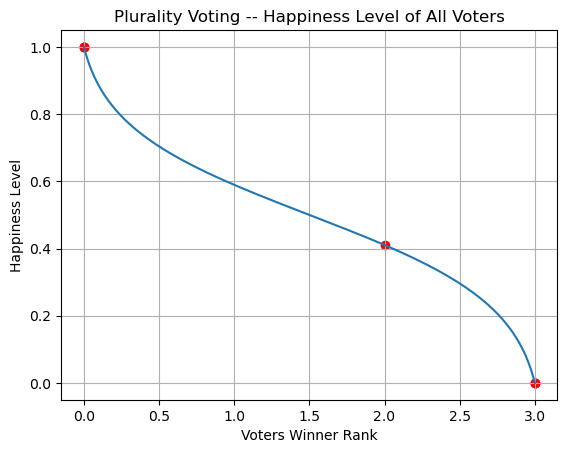


Histogram of Happiness Level


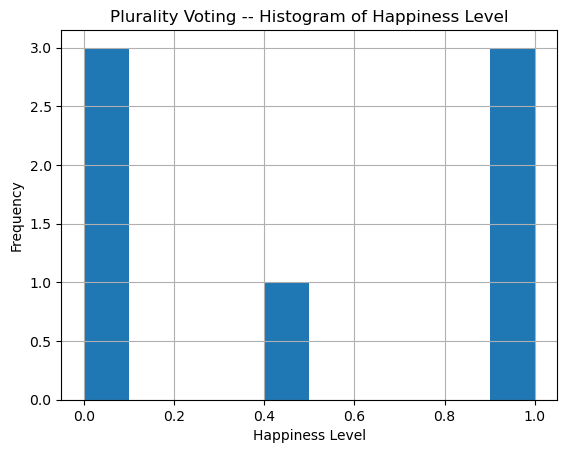

In [18]:
pv_h = HappinessLevel(
    voting,
    outcomes[VotingSchemas.PLURALITY_VOTING.value].winner,
    VotingSchemas.PLURALITY_VOTING,
).run(show=True)

### Voting for Two

Voters Happiness Level


,Happiness Level
0,0.589513
1,0.000000
2,0.410487
3,0.000000
4,0.589513
5,1.000000
6,1.000000



Overall Happiness Level: 3.589513409233281

Happiness Level Distribution


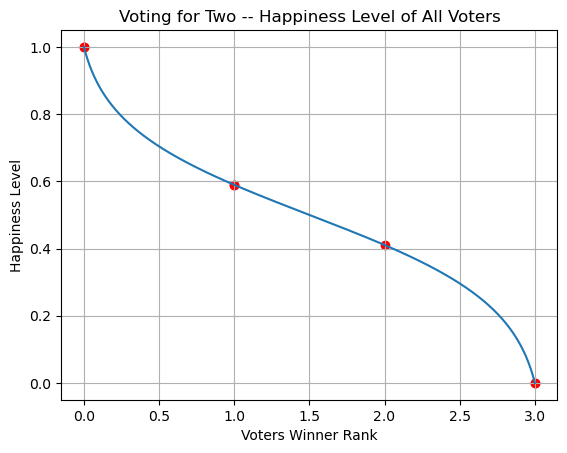


Histogram of Happiness Level


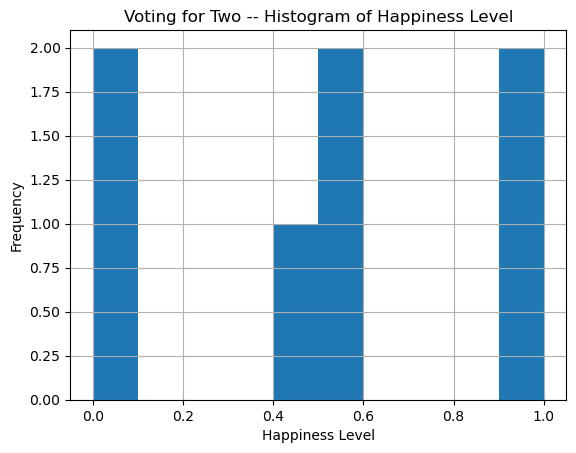

In [19]:
vt_h = HappinessLevel(
    voting,
    outcomes[VotingSchemas.VOTING_FOR_TWO.value].winner,
    VotingSchemas.VOTING_FOR_TWO,
).run(show=True)

### Veto Voting

Voters Happiness Level


,Happiness Level
0,0.410487
1,0.589513
2,0.589513
3,0.589513
4,0.410487
5,0.410487
6,0.410487



Overall Happiness Level: 3.410486590766719

Happiness Level Distribution


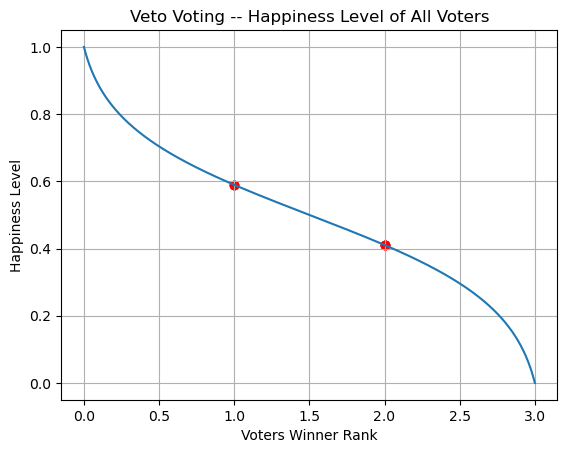


Histogram of Happiness Level


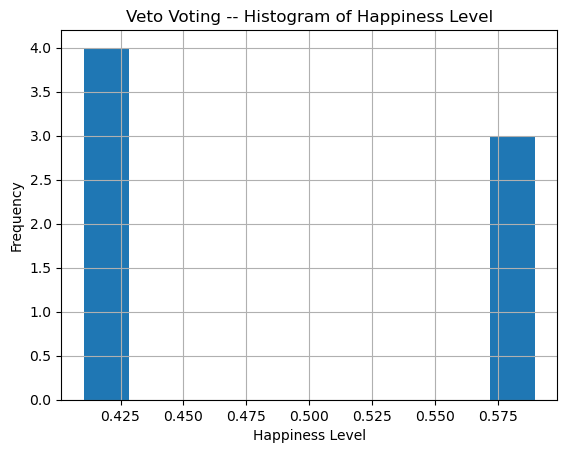

In [20]:
vv_h = HappinessLevel(
    voting,
    outcomes[VotingSchemas.VETO_VOTING.value].winner,
    VotingSchemas.VETO_VOTING,
).run(show=True)

### Borda Voting

Voters Happiness Level


,Happiness Level
0,0.589513
1,0.000000
2,0.410487
3,0.000000
4,0.589513
5,1.000000
6,1.000000



Overall Happiness Level: 3.589513409233281

Happiness Level Distribution


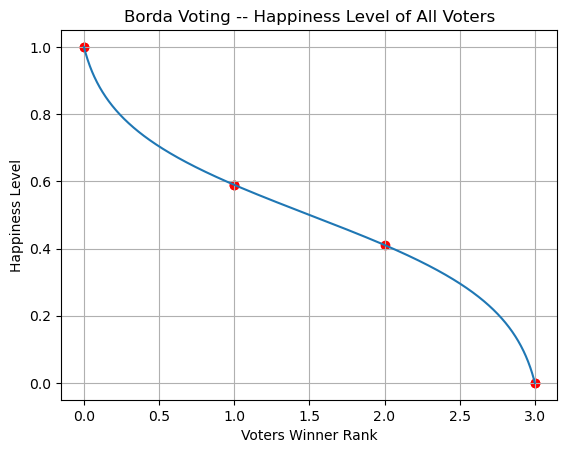


Histogram of Happiness Level


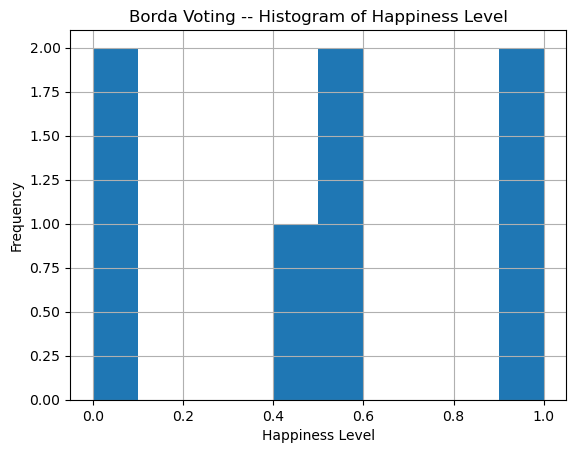

In [21]:
bv_h = HappinessLevel(
    voting,
    outcomes[VotingSchemas.BORDA_VOTING.value].winner,
    VotingSchemas.BORDA_VOTING,
).run(show=True)

## Strategic Voting

### Plurality Voting

In [22]:
pv_s = StrategicVoting(voting, pv_h, plurality_outcome).run(show=True)

Strategic Voting


,voter,strategic_voting,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H
0,4,"[A, B, D, C]",A,0.589513,0.0,3.589513,3.410487
1,4,"[A, D, B, C]",A,0.589513,0.0,3.589513,3.410487
2,5,"[B, A, D, C]",B,0.589513,0.0,3.589513,3.410487
3,5,"[B, D, A, C]",B,0.589513,0.0,3.589513,3.410487
4,6,"[B, A, D, C]",B,0.589513,0.0,3.589513,3.410487
5,6,"[B, D, A, C]",B,0.589513,0.0,3.589513,3.410487


Best Strategic Voting


,voter,strategic_voting,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H
0,4,"[A, B, D, C]",A,0.589513,0.0,3.589513,3.410487
2,5,"[B, A, D, C]",B,0.589513,0.0,3.589513,3.410487
4,6,"[B, A, D, C]",B,0.589513,0.0,3.589513,3.410487


Risk: 0.442135056924961


### Voting for Two

In [23]:
vt_s = StrategicVoting(voting, vt_h, for_two_outcome).run(show=True)

Strategic Voting


,voter,strategic_voting,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H
0,3,"[C, B, D, A]",B,0.410487,0.000000,3.589513,3.589513
1,3,"[D, B, C, A]",B,0.410487,0.000000,3.589513,3.589513
2,3,"[B, C, D, A]",B,0.410487,0.000000,3.589513,3.589513
3,3,"[B, D, C, A]",B,0.410487,0.000000,3.589513,3.589513
4,4,"[B, D, A, C]",B,1.000000,0.589513,3.589513,3.589513
5,4,"[B, D, C, A]",B,1.000000,0.589513,3.589513,3.589513
6,4,"[B, C, A, D]",B,1.000000,0.589513,3.589513,3.589513
7,4,"[B, C, D, A]",B,1.000000,0.589513,3.589513,3.589513
8,4,"[D, B, A, C]",B,1.000000,0.589513,3.589513,3.589513
9,4,"[D, B, C, A]",B,1.000000,0.589513,3.589513,3.589513


Best Strategic Voting


,voter,strategic_voting,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H
4,4,"[B, D, A, C]",B,1.000000,0.589513,3.589513,3.589513
0,3,"[C, B, D, A]",B,0.410487,0.000000,3.589513,3.589513


Risk: 0.16419463630668746


### Veto Voting

In [24]:
vv_s = StrategicVoting(voting, vv_h, veto_outcome).run(show=True)

Strategic Voting


,voter,strategic_voting,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H


Best Strategic Voting


,voter,strategic_voting,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H


Risk: 0.0


### Borda Voting

In [25]:
bv_s = StrategicVoting(voting, bv_h, borda_outcome).run(show=True)

Strategic Voting


,voter,strategic_voting,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H
0,1,"[C, B, D, A]",C,0.410487,0.000000,3.410487,3.589513
1,1,"[C, D, B, A]",C,0.410487,0.000000,3.410487,3.589513
2,3,"[C, B, D, A]",B,0.410487,0.000000,3.589513,3.589513
3,3,"[D, B, C, A]",B,0.410487,0.000000,3.589513,3.589513
4,3,"[B, C, D, A]",B,0.410487,0.000000,3.589513,3.589513
5,3,"[B, D, C, A]",B,0.410487,0.000000,3.589513,3.589513
6,4,"[B, D, A, C]",B,1.000000,0.589513,3.589513,3.589513
7,4,"[B, D, C, A]",B,1.000000,0.589513,3.589513,3.589513


Best Strategic Voting


,voter,strategic_voting,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H
6,4,"[B, D, A, C]",B,1.000000,0.589513,3.589513,3.589513
2,3,"[C, B, D, A]",B,0.410487,0.000000,3.589513,3.589513
0,1,"[C, B, D, A]",C,0.410487,0.000000,3.410487,3.589513


Risk: 0.2462919544600312


---
# Advanced TVA

## Coalitions

### Plurality Voting

In [27]:
c_pv = find_stable_coalitions(
    voting,
    VotingSchemas.PLURALITY_VOTING,
    plurality_outcome,
    strategy= 'compromising'
)

display(c_pv)

4
0.5895134092332813
  members number_members is_stable new_result strategic_H previous_H  \
0    (6,)              1       NaN        NaN    0.589513        0.0   

  average_coalition_change strategic_overall_H previous_overall_H  \
0                 0.589513                 NaN                NaN   

  average_overall_change  
0                    NaN  
0.5895134092332813
  members number_members is_stable new_result strategic_H previous_H  \
0    (6,)              1      True          B    0.589513        0.0   
1    (5,)              1       NaN        NaN    0.589513        0.0   

  average_coalition_change strategic_overall_H previous_overall_H  \
0                 0.589513            0.512788           0.487212   
1                 0.589513                 NaN                NaN   

  average_overall_change  
0               0.025575  
1                    NaN  
0.5895134092332813
  members number_members is_stable new_result strategic_H previous_H  \
0    (6,)              1 

,members,number_members,is_stable,new_result,strategic_H,previous_H,average_coalition_change,strategic_overall_H,previous_overall_H,average_overall_change
0,"(6,)",1,True,B,0.589513,0.0,0.589513,0.512788,0.487212,0.025575
1,"(5,)",1,True,B,0.589513,0.0,0.589513,0.512788,0.487212,0.025575
2,"(4,)",1,True,A,0.589513,0.0,0.589513,0.512788,0.487212,0.025575
3,"(5, 6)",2,True,B,0.589513,0.0,0.589513,0.512788,0.487212,0.025575
4,"(4, 5, 6)",3,True,B,0.726342,0.0,0.726342,0.512788,0.487212,0.025575
5,"(4, 5, 6)",3,True,A,0.863171,0.0,0.863171,0.512788,0.487212,0.025575
6,"(1, 5)",2,True,D,0.5,0.205243,0.294757,0.487212,0.487212,0.0
7,"(1, 6)",2,True,D,0.5,0.205243,0.294757,0.487212,0.487212,0.0
8,"(4, 5)",2,True,D,0.410487,0.0,0.410487,0.487212,0.487212,0.0
9,"(4, 5)",2,True,D,0.410487,0.0,0.410487,0.487212,0.487212,0.0


### Voting for Two

In [14]:
c_vt = find_stable_coalitions(
    voting,
    VotingSchemas.VOTING_FOR_TWO,
    for_two_outcome,
    strategy= 'compromising'
)

display(c_vt)

5
0.4104865907667187
  members number_members is_stable new_result strategic_H previous_H  \
0    (3,)              1       NaN        NaN    0.410487        0.0   

  average_coalition_change strategic_overall_H previous_overall_H  \
0                 0.410487                 NaN                NaN   

  average_overall_change  
0                    NaN  
1.4104865907667188
  members number_members is_stable new_result strategic_H previous_H  \
0    (3,)              1      True          B    0.410487        0.0   
1  (1, 3)              2       NaN        NaN    0.705243        0.0   

  average_coalition_change strategic_overall_H previous_overall_H  \
0                 0.410487            0.512788           0.512788   
1                 0.705243                 NaN                NaN   

  average_overall_change  
0                    0.0  
1                    NaN  


,members,number_members,is_stable,new_result,strategic_H,previous_H,average_coalition_change,strategic_overall_H,previous_overall_H,average_overall_change
0,"(3,)",1,True,B,0.410487,0.0,0.410487,0.512788,0.512788,0.0
1,"(1, 3)",2,True,B,0.705243,0.0,0.705243,0.512788,0.512788,0.0


### Veto Voting

In [ ]:
c_vv = find_stable_coalitions(
    voting,
    VotingSchemas.VETO_VOTING,
    veto_outcome,
    strategy = 'burying'
)

display(c_vv)

,coalition_group,voter,strategic_voting,is_stable,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H


### Borda Voting

In [ ]:
cp_bv = find_stable_coalitions(
    pd.DataFrame(voting).T,
    VotingSchemas.BORDA_VOTING,
    borda_outcome,
    strategy= 'compromising'
)
display(cp_bv)

{'D', 'C'}
Pushing D made everyone in the group 5 happier, here the new winner:   {'A': 11, 'B': 11, 'C': 8, 'D': 12}
is it stable?
True
{'D', 'C'}
Pushing D made everyone in the group 10 happier, here the new winner:   {'A': 11, 'B': 10, 'C': 8, 'D': 13}
is it stable?
True
{'D', 'C'}
Pushing C made everyone in the group 10 happier, here the new winner:   {'A': 11, 'B': 10, 'C': 12, 'D': 9}
is it stable?
True


,coalition_group,voter,strategic_voting,is_stable,new_result,strategic_H,previous_H,strategic_overall_H,previous_overall_H
0,5,2,"[D, C, A, B]",True,D,0.589513,0.410487,3.410487,3.589513
1,5,3,"[D, C, B, A]",True,D,0.589513,0.000000,3.410487,3.589513
2,10,1,"[D, B, C, A]",True,D,0.589513,0.000000,3.410487,3.589513
3,10,2,"[D, C, A, B]",True,D,0.589513,0.410487,3.410487,3.589513
4,10,3,"[D, C, B, A]",True,D,0.589513,0.000000,3.410487,3.589513
5,10,1,"[C, B, D, A]",True,C,0.410487,0.000000,3.410487,3.589513
6,10,2,"[C, D, A, B]",True,C,1.000000,0.410487,3.410487,3.589513
7,10,3,"[C, D, B, A]",True,C,1.000000,0.000000,3.410487,3.589513
